# Import Library

In [1]:
# Import library yang diperlukan
import pandas as pd
import numpy as np
import os
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras import models
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import TensorBoard
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

# Muat Dataset

            Location                        Filename  Year  Month  Day   Hour  \
0  Biratnagar, Nepal  BRI_Un_2023-02-02- 12.00-9.jpg  2023      2    2  12:00   
1  Biratnagar, Nepal  BRI_Un_2023-02-02- 12.00-8.jpg  2023      2    2  12:00   
2  Biratnagar, Nepal  BRI_Un_2023-02-02- 12.00-7.jpg  2023      2    2  12:00   
3  Biratnagar, Nepal  BRI_Un_2023-02-02- 12.00-6.jpg  2023      2    2  12:00   
4  Biratnagar, Nepal  BRI_Un_2023-02-02- 12.00-5.jpg  2023      2    2  12:00   

   AQI  PM2.5    PM10     O3    CO  SO2   NO2    AQI_Class  
0  158  70.08  100.82  58.89  0.49  4.4  1.04  d_Unhealthy  
1  158  70.08  100.82  58.89  0.49  4.4  1.04  d_Unhealthy  
2  158  70.08  100.82  58.89  0.49  4.4  1.04  d_Unhealthy  
3  158  70.08  100.82  58.89  0.49  4.4  1.04  d_Unhealthy  
4  158  70.08  100.82  58.89  0.49  4.4  1.04  d_Unhealthy  


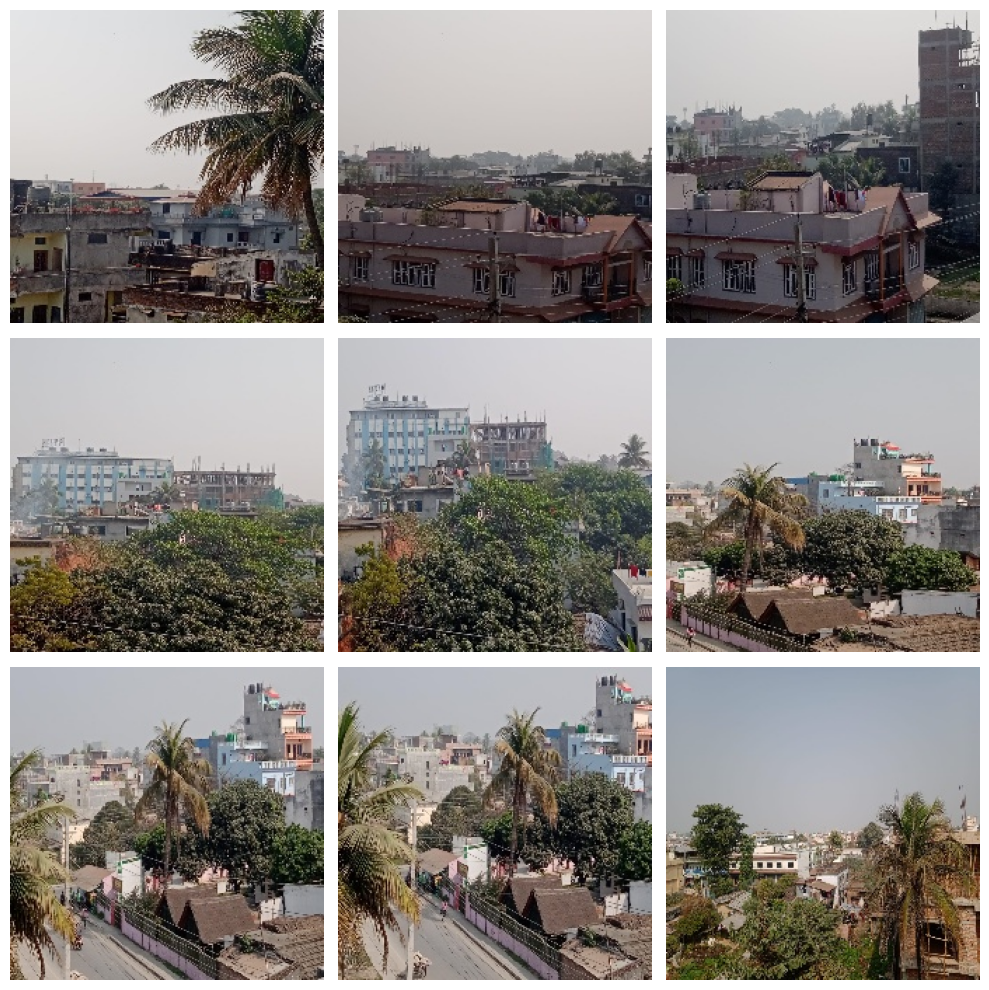

In [3]:
# Load dataset
df = pd.read_csv('IND_and_Nep_AQI_Dataset.csv')

# Tampilkan beberapa data pertama
print(df.head())

# Path folder gambar
image_folder = 'All_img/'

# Menampilkan beberapa gambar contoh
sample_images = df['Filename'].head(9).apply(lambda x: os.path.join(image_folder, x))

# Plotting 9 gambar pertama
fig, axes = plt.subplots(3, 3, figsize=(10, 10))  # Menampilkan 9 gambar dalam grid 3x3
axes = axes.ravel()  # Flatten array axes untuk memudahkan indexing

for i, img_path in enumerate(sample_images):
    img = tf.keras.preprocessing.image.load_img(img_path)
    axes[i].imshow(img)
    axes[i].axis('off')  # Menonaktifkan sumbu (axis) di gambar

plt.tight_layout()
plt.show()

# Pembagian Data Training dan Validation

In [5]:
# Membagi dataframe menjadi train (80%) dan remaining (20%)
train_df, remaining_df = train_test_split(df, test_size=0.2, stratify=df['AQI_Class'], random_state=42)

# Membagi remaining menjadi validation (50%) dan testing (50%)
val_df, test_df = train_test_split(remaining_df, test_size=0.5, stratify=remaining_df['AQI_Class'], random_state=42)

# Menampilkan ukuran data
print(f"Training data size: {len(train_df)}")
print(f"Validation data size: {len(val_df)}")
print(f"Testing data size: {len(test_df)}")

Training data size: 9792
Validation data size: 1224
Testing data size: 1224


# Data Augmentation dan Data Generator

In [7]:
# Menyiapkan ImageDataGenerator dengan augmentasi
datagen = ImageDataGenerator(
    rescale=1./255,            # Normalisasi piksel
    rotation_range=30,         # Rotasi acak hingga ±30 derajat
    zoom_range=0.2,           # Zoom acak hingga 20%
    horizontal_flip=True,     # Membalik gambar secara horizontal
    shear_range=0.2,          # Shear (transformasi diagonal) hingga 20%
)

# Membuat generator untuk data pelatihan dengan augmentasi
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=image_folder,
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

# Membuat generator untuk data validasi tanpa augmentasi
val_generator = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=image_folder,
    x_col='Filename',
    y_col='AQI_Class',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 9792 validated image filenames belonging to 6 classes.
Found 1224 validated image filenames belonging to 6 classes.


# Arsitektur Model CNN

In [9]:
# Membuat model CNN
model = models.Sequential([
    Input(shape=(128, 128, 3)),                # Input layer dengan resolusi gambar
    Conv2D(32, (3, 3), activation='relu'),     # Convolutional layer pertama
    MaxPooling2D((2, 2)),                      # Pooling layer pertama
    Conv2D(64, (3, 3), activation='relu'),     # Convolutional layer kedua
    MaxPooling2D((2, 2)),                      # Pooling layer kedua
    Conv2D(128, (3, 3), activation='relu'),    # Convolutional layer ketiga
    MaxPooling2D((2, 2)),                      # Pooling layer ketiga
    Flatten(),                                 # Flattening layer
    Dense(128, activation='relu'),             # Fully connected layer
    Dense(len(df['AQI_Class'].unique()), activation='softmax')  # Output layer
])

model.summary()

# Kompilasi model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,305,414 (12.61 MB)

 Trainable params: 3,305,414 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

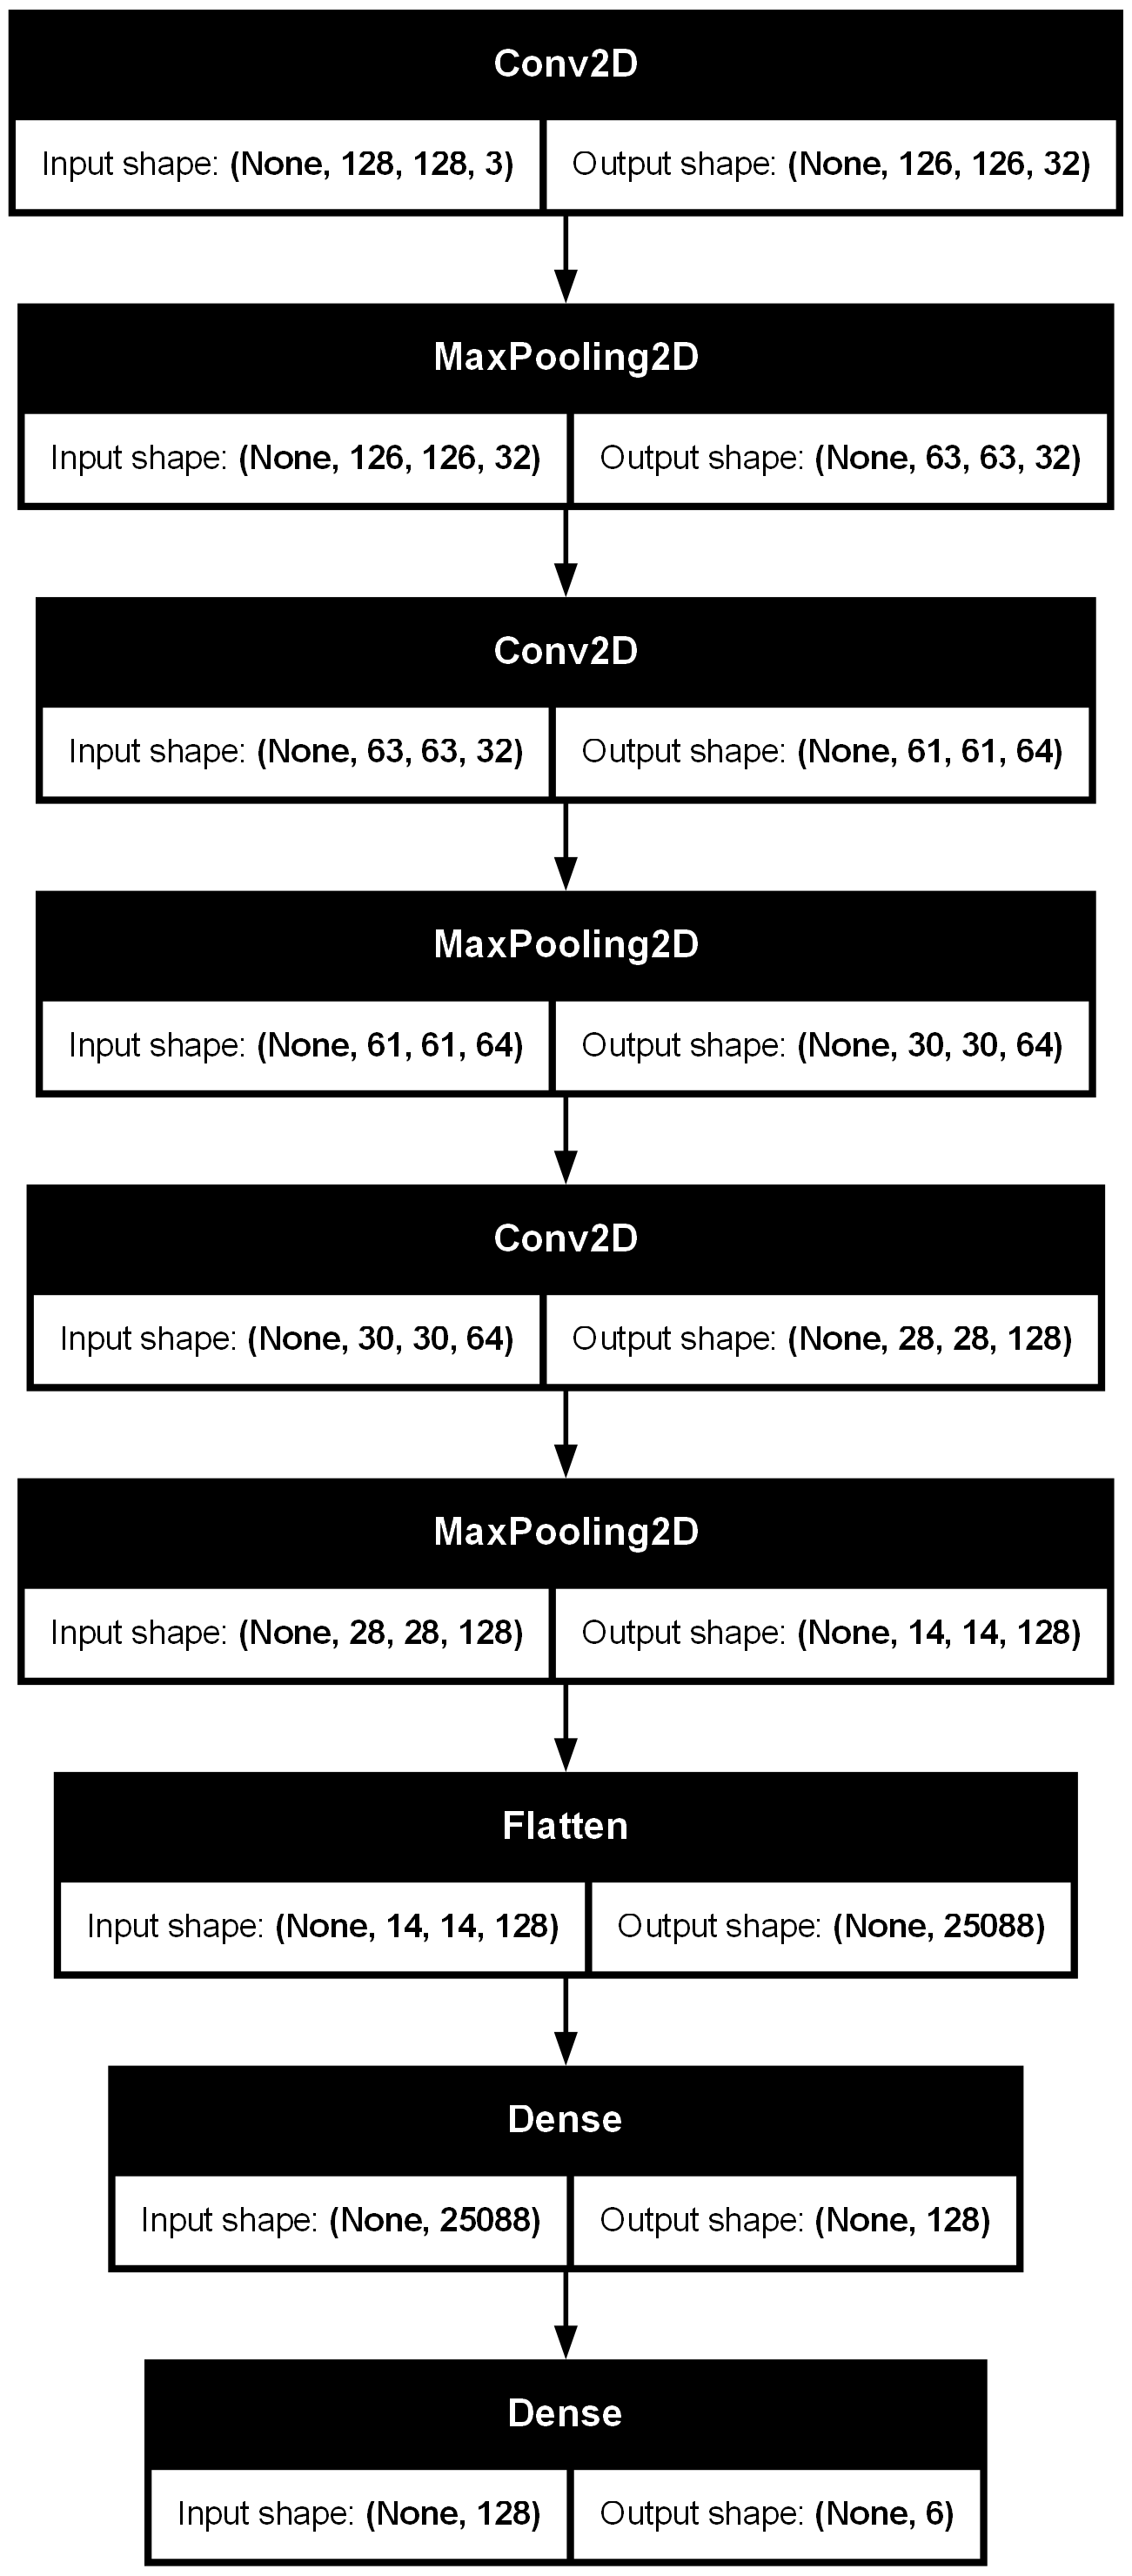

In [11]:
tf.keras.utils.plot_model(model,show_shapes=True)

# Pelatihan Model

In [13]:
# Callback untuk TensorBoard
log_dir = os.path.join("logs", "fit", "air_pollution_model")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# Melatih model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=val_generator,
    callbacks=[tensorboard_callback]
)

C:\Users\REDMI\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 91s 291ms/step - accuracy: 0.3575 - loss: 1.5372 - val_accuracy: 0.5498 - val_loss: 1.1190
Epoch 2/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 89s 290ms/step - accuracy: 0.5651 - loss: 1.0644 - val_accuracy: 0.6152 - val_loss: 0.9673
Epoch 3/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 98s 319ms/step - accuracy: 0.6277 - loss: 0.8997 - val_accuracy: 0.6904 - val_loss: 0.7746
Epoch 4/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 100s 327ms/step - accuracy: 0.7078 - loss: 0.7162 - val_accuracy: 0.7075 - val_loss: 0.7402
Epoch 5/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 93s 305ms/step - accuracy: 0.7313 - loss: 0.6730 - val_accuracy: 0.7361 - val_loss: 0.6451
Epoch 6/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 87s 284ms/step - accuracy: 0.7643 - loss: 0.5801 - val_accuracy: 0.7770 - val_loss: 0.5819
Epoch 7/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 89s 292ms/step - accuracy: 0.7848 - loss: 0.5365 - val_accuracy: 0.7859 - val_loss: 0.5513
Epoch 8/10
306/306 ━━━━━━━━━━━━━━━━━━━━ 101s 328ms/step - accuracy: 0.8093 - loss:

# Visualisasi Performa Model

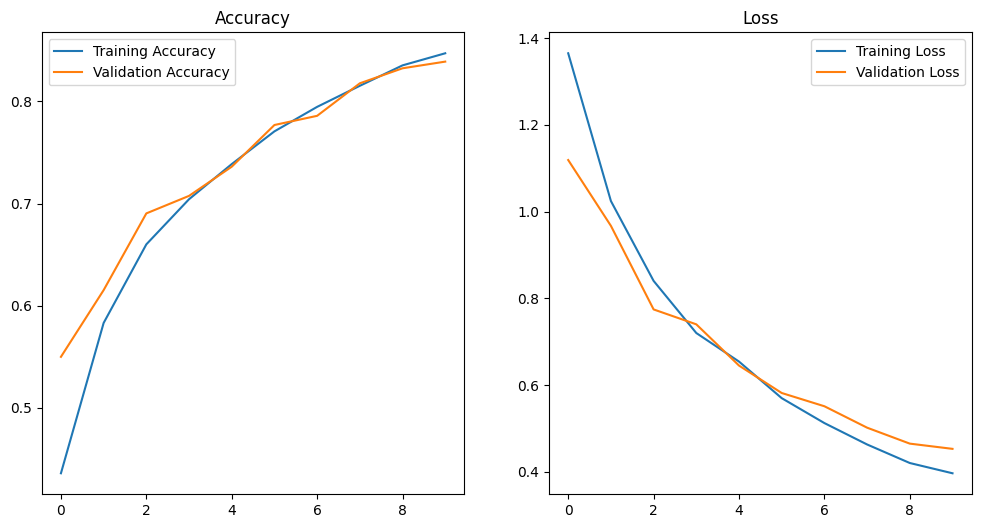

In [15]:
# Plotting accuracy dan loss
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].plot(history.history['accuracy'], label='Training Accuracy')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy')
axes[0].set_title('Accuracy')
axes[0].legend()

axes[1].plot(history.history['loss'], label='Training Loss')
axes[1].plot(history.history['val_loss'], label='Validation Loss')
axes[1].set_title('Loss')
axes[1].legend()

plt.show()

# Evaluasi Model

39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 147ms/step - accuracy: 0.8337 - loss: 0.4418
Test Loss: 0.4385
Test Accuracy: 84.07%
39/39 ━━━━━━━━━━━━━━━━━━━━ 6s 137ms/step

Classification Report:
                                  precision    recall  f1-score   support

                          a_Good       0.70      0.82      0.76       154
                      b_Moderate       0.86      0.69      0.77       157
c_Unhealthy_for_Sensitive_Groups       0.78      0.80      0.79       287
                     d_Unhealthy       0.88      0.89      0.89       262
                e_Very_Unhealthy       0.95      0.87      0.91       220
                        f_Severe       0.86      0.92      0.89       144

                        accuracy                           0.84      1224
                       macro avg       0.84      0.83      0.83      1224
                    weighted avg       0.84      0.84      0.84      1224


Confusion Matrix:
[[127   9  13   3   0   2]
 [ 22 109  22   4   0   0]
 [ 2

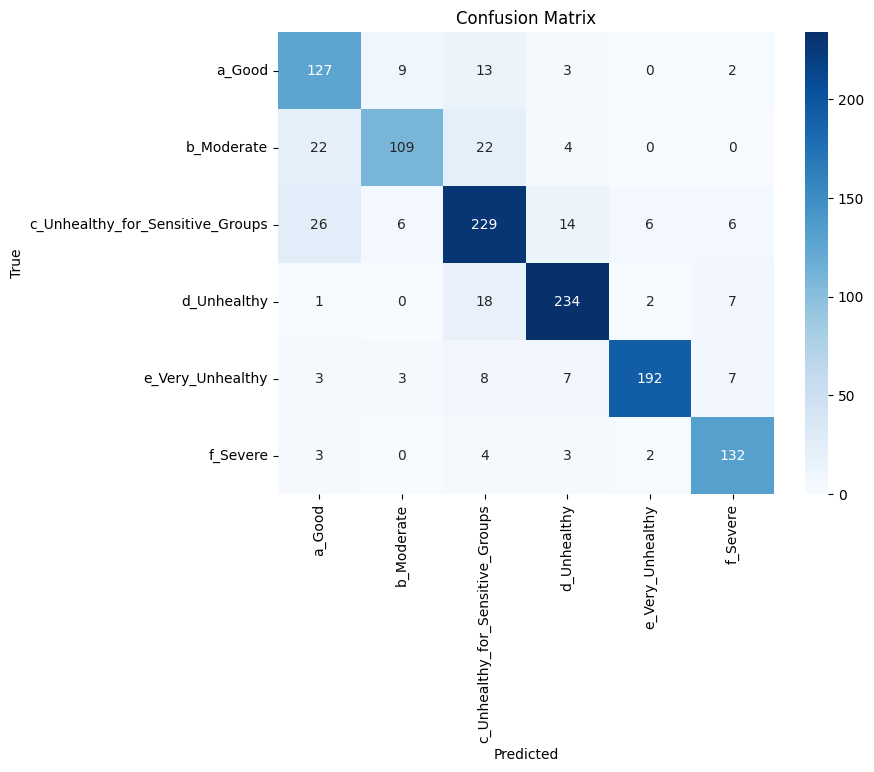

In [17]:
# Evaluasi model pada data validasi
test_loss, test_accuracy = model.evaluate(val_generator)

# Menampilkan hasil evaluasi
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")

# Melakukan prediksi pada data validasi
predictions = model.predict(val_generator)

# Mengambil label prediksi dan label asli
y_pred = np.argmax(predictions, axis=1)  # Mengambil kelas dengan probabilitas tertinggi
y_true = val_generator.classes           # Kelas asli dari generator

# Menampilkan classification report (precision, recall, f1-score)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=val_generator.class_indices.keys()))

# Menampilkan confusion matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
print(cm)

# Visualisasi confusion matrix
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Save Model

In [19]:
# Menyimpan model ke file .h5
model.save('air_pollution_model.h5')

print("Model telah disimpan sebagai 'air_pollution_model.h5'")

Model telah disimpan sebagai 'air_pollution_model.h5'


In [21]:
import os
import shutil

# Folder tujuan untuk data testing
test_folder = 'Test_Data/'
image_folder = 'All_img/'  # Folder asal gambar

# Membuat folder tujuan jika belum ada
if not os.path.exists(test_folder):
    os.makedirs(test_folder)

# Membuat subfolder untuk gambar
test_image_folder = os.path.join(test_folder, 'images')
if not os.path.exists(test_image_folder):
    os.makedirs(test_image_folder)

# Memindahkan gambar yang sesuai ke folder baru
for img_name in test_df['Filename']:
    # Path sumber dan tujuan gambar
    src_path = os.path.join(image_folder, img_name)
    dst_path = os.path.join(test_image_folder, img_name)
    
    # Memindahkan gambar ke folder tujuan
    if os.path.exists(src_path):
        shutil.copy(src_path, dst_path)